# MNIST Handwritten Digit Recognition – Neural Network Training
Abdullah Çifçi 220611037

This Colab study demonstrates the training process of a simple artificial neural network (ANN) model on the MNIST dataset, which is widely used for handwritten digit classification. The implementation is based on the network2.py file provided in the GitHub repository assigned to us. All code was integrated directly into Colab without requiring any external file uploads.

The MNIST dataset consists of 28×28 grayscale images of handwritten digits and serves as a standard benchmark for evaluating machine learning models. In this study, each image was converted into a 784-dimensional vector to be used as input for the neural network. The training labels were transformed into one-hot encoded vectors, a common representation for classification tasks, to ensure compatibility with the model.

The constructed model is a fully connected feedforward neural network and consists of three layers defined as [784, 30, 10]:

784 input neurons (one for each pixel),

a hidden layer with 30 neurons,

and an output layer with 10 neurons (representing digits 0–9).

Training was carried out using the Mini-Batch Stochastic Gradient Descent (SGD) algorithm. The activation function used in all layers is sigmoid, while the cost function is Cross-Entropy, which generally provides more stable results in classification problems. During training, the model was optimized using specific hyperparameters, and its performance was evaluated using accuracy on the test dataset.

The purpose of this Colab work is not only to build a basic neural network but also to conduct three different hyperparameter experiments—learning rate, mini-batch size, and hidden layer neuron count—to analyze how these parameters affect model performance. This enables students to practically observe the dynamics of neural networks and understand how different factors influence the training process.

🔹 Cell 1 – Basic libraries and helper functions

In this cell:

We import the numpy and random libraries,

We define the sigmoid activation function,

We define the derivative of the sigmoid function,

We implement the vectorized_result function, which converts labels into one-hot vectors.

In [ ]:
# Hücre 1: Temel kütüphaneler ve yardımcı fonksiyonlar

import numpy as np
import random
import matplotlib.pyplot as plt

def sigmoid(z):
    """
    Sigmoid aktivasyon fonksiyonu.
    Girdi: z (skaler veya numpy array)
    Çıktı: 1 / (1 + e^(-z))
    """
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """
    Sigmoid fonksiyonunun türevi.
    sigmoid(z) * (1 - sigmoid(z))
    """
    s = sigmoid(z)
    return s * (1 - s)

def vectorized_result(j):
    """
    0-9 arasındaki sayısal etiketi (ör: 3)
    10 boyutlu bir one-hot vektöre çevirir:
    3 -> [0,0,0,1,0,0,0,0,0,0]^T
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


🔹 Cell 2 – Cost functions

In this cell:

We define the QuadraticCost (MSE) class,

We define the CrossEntropyCost, which is generally more effective for classification tasks.

In [ ]:
# Hücre 2: Cost (maliyet) fonksiyonları

class QuadraticCost(object):
    """
    Klasik karesel hata (Mean Squared Error) cost fonksiyonu.
    """

    @staticmethod
    def fn(a, y):
        """
        a: ağın çıktısı
        y: hedef çıktı (etiket)
        Çıktı: 0.5 * ||a - y||^2
        """
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        """
        Çıkış katmanındaki hata terimi (delta).
        Quadratic + sigmoid kullandığımız için
        (a - y) * sigmoid_prime(z) formu kullanılır.
        """
        return (a - y) * sigmoid_prime(z)


class CrossEntropyCost(object):
    """
    Sınıflandırma problemleri için daha uygun olan
    Cross-Entropy cost fonksiyonu.
    """

    @staticmethod
    def fn(a, y):
        """
        a: ağın çıktısı
        y: hedef çıktı (one-hot vektör)
        """
        return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """
        Cross-Entropy + sigmoid kombinasyonunda
        türev sadeleştiği için sadece (a - y) kalır.
        z kullanılmıyor ama arayüz aynı kalsın diye parametre var.
        """
        return (a - y)


🔹 Cell 3 – Network class (entire network in one cell)

In this cell:

We define the Network class,

Initialize weights and biases,

Implement feedforward computation,

Implement the training process (SGD),

Update parameters with mini-batch gradient descent (update_mini_batch),

Implement backpropagation,

Compute accuracy on the evaluation dataset.

In [ ]:
# Hücre 3: Network sınıfı (tam sinir ağı tanımı)

class Network(object):
    """
    Basit tam bağlantılı (fully-connected) ileri beslemeli sinir ağı.
    sizes: [784, 30, 10] gibi katman nöron sayıları listesi
    cost: kullanılacak cost sınıfı (CrossEntropyCost, QuadraticCost vs.)
    """

    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.cost = cost
        self.default_weight_initializer()

    def default_weight_initializer(self):
        """
        Ağırlıkları ve biasları başlat.
        Biaslar: N(0,1)
        Ağırlıklar: N(0, 1/sqrt(n_girdi)) ile ölçeklenmiş.
        """
        self.biases = [
            np.random.randn(y, 1) for y in self.sizes[1:]
        ]
        self.weights = [
            np.random.randn(y, x) / np.sqrt(x)
            for x, y in zip(self.sizes[:-1], self.sizes[1:])
        ]

    def feedforward(self, a):
        """
        Girdi vektörünü (a) alır, katman katman geçirip çıkış vektörünü döner.
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0,
            evaluation_data=None,
            monitor_evaluation_accuracy=False):
        """
        Mini-batch Stochastic Gradient Descent ile eğitimi gerçekleştirir.

        training_data: (x, y) tuple'larından oluşan liste
        epochs: kaç dönem (tüm veri üzerinden) geçileceği
        mini_batch_size: her adımda kaç örnek kullanılacağı
        eta: öğrenme oranı (learning rate)
        lmbda: L2 regularization katsayısı
        evaluation_data: genelde test verisi
        monitor_evaluation_accuracy: True ise her epoch sonunda doğruluğu yazar
        """
        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data is not None:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)
        else:
            n_data = 0

        for epoch in range(epochs):
            # 1) Veriyi karıştır
            random.shuffle(training_data)

            # 2) Mini-batch'lere böl
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            # 3) Her mini-batch için ağırlıkları güncelle
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, n)

            # 4) Epoch sonucu yazdır
            print(f"Epoch {epoch+1}/{epochs} tamamlandı")

            if evaluation_data is not None and monitor_evaluation_accuracy:
                acc = self.accuracy(evaluation_data)
                print(f"  Test doğruluğu: {acc} / {n_data}")

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """
        Tek bir mini-batch için ağırlık ve bias güncellemesi yapar.
        L2 regularization (weight decay) de burada uygulanır.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Her örnek için backprop ile gradyanları topla
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        # Ağırlık ve bias güncellemesi
        self.weights = [
            (1 - eta * (lmbda / n)) * w - (eta / len(mini_batch)) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch)) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """
        Backpropagation algoritması:
        Verilen x girdisi ve y hedefi için
        dC/db ve dC/dw (gradyanlar) döner.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # 1) İleri besleme
        activation = x
        activations = [x]  # her katmandaki aktivasyonlar
        zs = []            # her katmandaki z = w·a + b değerleri

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # 2) Çıkış katmanı hatası (delta_L)
        delta = self.cost.delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # 3) Geriye doğru katman katman hata hesabı
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """
        Doğru sınıflandırılan örnek sayısını döner.
        data: (x, y) listesi
        convert=False: y etiketleri integer ise False (test verisi)
        convert=True: y etiketleri one-hot ise (eğitim verisi gibi)
        """
        if convert:
            results = [
                (np.argmax(self.feedforward(x)), np.argmax(y))
                for (x, y) in data
            ]
        else:
            results = [
                (np.argmax(self.feedforward(x)), y)
                for (x, y) in data
            ]
        return sum(int(x == y) for (x, y) in results)


In [ ]:
# Hücre X: Network özeti için yardımcı fonksiyonlar

import pandas as pd

def summarize_network(net):
    """
    Verilen Network nesnesinin katmanlarını ve parametre sayılarını
    tablo halinde gösterir.
    """
    rows = []
    total_params = 0

    # Giriş katmanı dahil katman boyutlarını alalım
    layer_sizes = net.sizes  # örn: [784, 30, 10]

    for layer_idx, (in_size, out_size, w, b) in enumerate(
        zip(layer_sizes[:-1], layer_sizes[1:], net.weights, net.biases),
        start=1
    ):
        num_weights = w.size   # w.shape[0] * w.shape[1]
        num_biases = b.size    # b.shape[0]
        params = num_weights + num_biases
        total_params += params

        rows.append({
            "Layer": f"{layer_idx}: {in_size} → {out_size}",
            "#Weights": num_weights,
            "#Biases": num_biases,
            "Total Params": params
        })

    df = pd.DataFrame(rows)
    print("🔎 Ağ Özeti:")
    display(df)
    print(f"🧮 Toplam Parametre Sayısı: {total_params}")


# Örnek: MNIST ağı oluşturup özetini gösterelim
net = Network([784, 30, 10], cost=CrossEntropyCost)
summarize_network(net)


🔎 Ağ Özeti:


,Layer,#Weights,#Biases,Total Params
0,1: 784 → 30,23520,30,23550
1,2: 30 → 10,300,10,310


🧮 Toplam Parametre Sayısı: 23860


🔹 Cell 4 – Load MNIST from Keras and convert it to the network2 format

In this cell:

We load the MNIST dataset from Keras,

Convert each image from 28×28 into a 784×1 vector,

Normalize the inputs to the 0–1 range,

Convert training labels into one-hot vectors,

Prepare the training_data and test_data lists.

In [ ]:
# Hücre 4: MNIST verisini yükle ve uygun formata çevir

from tensorflow.keras.datasets import mnist

# Keras üzerinden MNIST'i al (ilk seferinde arka planda indirir)
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# 28x28 -> 784x1 ve 0-1 aralığına normalizasyon
train_x = train_x.reshape(-1, 784, 1).astype("float32") / 255.0
test_x  = test_x.reshape(-1, 784, 1).astype("float32") / 255.0

# Eğitim etiketlerini one-hot vektöre çevir
train_y_oh = [vectorized_result(y) for y in train_y]

# network2 stilinde (x, y) listeleri
training_data = list(zip(train_x, train_y_oh))  # y = one-hot
test_data = list(zip(test_x, test_y))          # y = integer

print("Eğitim örneği sayısı:", len(training_data))
print("Test örneği sayısı   :", len(test_data))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Eğitim örneği sayısı: 60000
Test örneği sayısı   : 10000


🔹 Cell 5 – Train the baseline (reference) model

In this cell:

We build the 784–30–10 network architecture,

We train the model for 5 epochs,

After each epoch, we print the test accuracy.

In [ ]:
# Hücre 5: Baz model (784-30-10) ile eğitim

# Ağ: 784 giriş, 30 gizli, 10 çıkış
net = Network([784, 30, 10], cost=CrossEntropyCost)

# Hiperparametreler:
epochs = 5
mini_batch_size = 10
eta = 0.5
lmbda = 5.0  # L2 regularization katsayısı

net.SGD(
    training_data,
    epochs=epochs,
    mini_batch_size=mini_batch_size,
    eta=eta,
    lmbda=lmbda,
    evaluation_data=test_data,
    monitor_evaluation_accuracy=True
)

final_acc = net.accuracy(test_data)
print("\nBaz model son test doğruluğu:", final_acc, "/", len(test_data))


Epoch 1/5 tamamlandı
  Test doğruluğu: 9438 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9508 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9533 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9536 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9544 / 10000

Baz model son test doğruluğu: 9544 / 10000


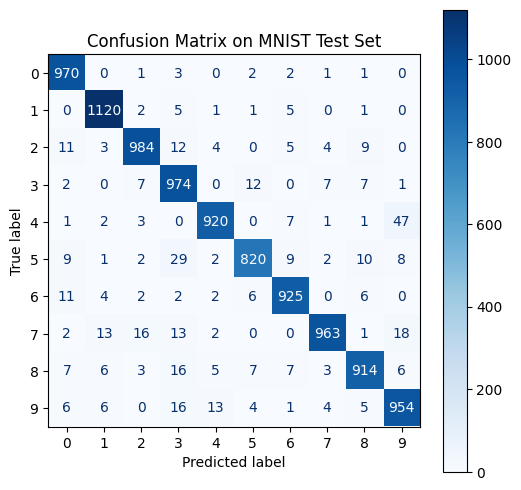

In [ ]:
# Hücre F: Confusion matrix hesaplama ve çizme

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(net, data):
    """
    Verilen network ve data için:
    - y_true: gerçek etiketler
    - y_pred: modelin tahmin ettiği etiketler
    döner.
    """
    y_true = []
    y_pred = []
    for x, y in data:
        y_true.append(int(y))  # test_data'da y integer
        y_pred.append(int(np.argmax(net.feedforward(x))))
    return np.array(y_true), np.array(y_pred)

# Test veri seti için tahminleri al
y_true, y_pred = get_predictions(net, test_data)

# Confusion matrix oluştur
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

# Görselleştir
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title("Confusion Matrix on MNIST Test Set")
plt.show()


In [ ]:
# Hücre G: Her sayı için ayrı accuracy hesabı

class_totals = cm.sum(axis=1)       # her satır: o sınıfa ait toplam örnek sayısı
class_correct = np.diag(cm)        # köşegen: doğru sınıflandırılanlar
class_acc = class_correct / class_totals

for digit in range(10):
    print(f"Digit {digit}: "
          f"{class_acc[digit]*100:.2f}% accuracy "
          f"(correct {class_correct[digit]}/{class_totals[digit]})")


Digit 0: 98.98% accuracy (correct 970/980)
Digit 1: 98.68% accuracy (correct 1120/1135)
Digit 2: 95.35% accuracy (correct 984/1032)
Digit 3: 96.44% accuracy (correct 974/1010)
Digit 4: 93.69% accuracy (correct 920/982)
Digit 5: 91.93% accuracy (correct 820/892)
Digit 6: 96.56% accuracy (correct 925/958)
Digit 7: 93.68% accuracy (correct 963/1028)
Digit 8: 93.84% accuracy (correct 914/974)
Digit 9: 94.55% accuracy (correct 954/1009)


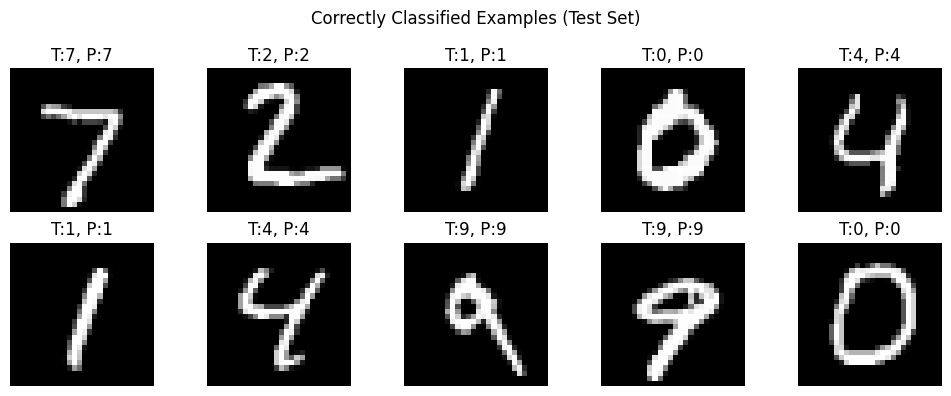

In [ ]:
# Hücre H: Doğru sınıflanan örneklerden bazılarını göster

def show_examples(images, labels_true, labels_pred, title, rows=2, cols=5):
    """
    images: (784,1) vektörler listesi
    labels_true: gerçek etiket listesi
    labels_pred: tahmin listesi
    """
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(rows*cols):
        img = images[i].reshape(28, 28)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"T:{labels_true[i]}, P:{labels_pred[i]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# test_data'dan X, y listeleri çıkar
X_test = [x for (x, y) in test_data]
y_test_true = [int(y) for (x, y) in test_data]
y_test_pred = [int(np.argmax(net.feedforward(x))) for x in X_test]

# index listeleri
correct_idx = [i for i, (yt, yp) in enumerate(zip(y_test_true, y_test_pred)) if yt == yp]

# ilk 10 doğru örneği göster
correct_sample_idx = correct_idx[:10]

show_examples(
    [X_test[i] for i in correct_sample_idx],
    [y_test_true[i] for i in correct_sample_idx],
    [y_test_pred[i] for i in correct_sample_idx],
    title="Correctly Classified Examples (Test Set)"
)


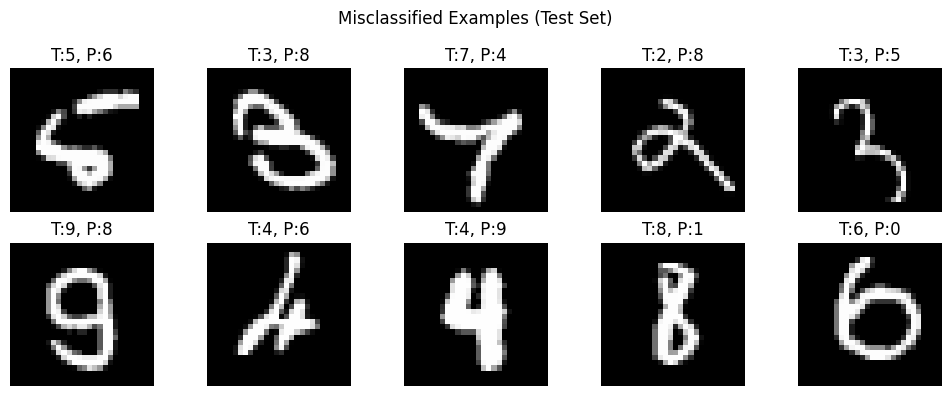

In [ ]:
# Hücre I: Yanlış sınıflanan örneklerden bazılarını göster

wrong_idx = [i for i, (yt, yp) in enumerate(zip(y_test_true, y_test_pred)) if yt != yp]

# Yanlış sınıflanan örnek sayısı az ise [:10] yerine hepsini de gösterebilirsin
wrong_sample_idx = wrong_idx[:10]

show_examples(
    [X_test[i] for i in wrong_sample_idx],
    [y_test_true[i] for i in wrong_sample_idx],
    [y_test_pred[i] for i in wrong_sample_idx],
    title="Misclassified Examples (Test Set)"
)


In [ ]:
# Hücre W: Örnek tahmin tablosu

def show_sample_predictions(net, data, num_samples=10, convert_y=False):
    samples = random.sample(list(data), num_samples)
    rows = []

    for idx, (x, y) in enumerate(samples):
        out = net.feedforward(x)
        pred = int(np.argmax(out))
        true_label = int(np.argmax(y)) if convert_y else int(y)

        rows.append({
            "Sample": idx + 1,
            "True Label": true_label,
            "Predicted": pred,
            "Correct?": pred == true_label
        })

    df = pd.DataFrame(rows)
    display(df)

# Örnek kullanım:
show_sample_predictions(net, test_data, num_samples=15, convert_y=False)


,Sample,True Label,Predicted,Correct?
0,1,4,4,True
1,2,7,7,True
2,3,0,0,True
3,4,8,8,True
4,5,5,5,True
5,6,8,8,True
6,7,3,3,True
7,8,2,2,True
8,9,3,3,True
9,10,8,8,True


In [ ]:
# Hücre Y: Eğitim sonuçlarını tablo halinde loglamak

def train_with_logging(net, training_data, evaluation_data,
                       epochs=10, mini_batch_size=32, eta=0.5, lmbda=0.0):
    training_data = list(training_data)
    evaluation_data = list(evaluation_data)
    n_data = len(evaluation_data)
    history = []

    for epoch in range(epochs):
        random.shuffle(training_data)
        mini_batches = [
            training_data[k:k+mini_batch_size]
            for k in range(0, len(training_data), mini_batch_size)
        ]
        for mini_batch in mini_batches:
            net.update_mini_batch(mini_batch, eta, lmbda, len(training_data))

        acc = net.accuracy(evaluation_data)
        history.append({
            "Epoch": epoch + 1,
            "Accuracy": acc,
            "Total Samples": n_data,
            "Accuracy (%)": 100.0 * acc / n_data
        })

        print(f"Epoch {epoch+1}: {acc}/{n_data}")

    df = pd.DataFrame(history)
    display(df)
    return df

🔹 Cell 6 – Experiment 1: Effect of the learning rate (η)

In this cell:

We rebuild and train the network from scratch using different learning rate values (0.1, 0.5, 3.0),

For each run, we print the final test accuracy,

All other parameters (epochs, batch size, lambda, architecture) remain constant.

In [ ]:
# Hücre 6: Deney 1 - Öğrenme oranının (eta) etkisi

def run_experiment_eta(eta_value, epochs=5):
    """
    Belirli bir öğrenme oranı (eta) için ağı baştan kurar,
    eğitir ve son test doğruluğunu döner.
    """
    print(f"\n=== Deney 1 - Öğrenme oranı: eta = {eta_value} ===")

    # Her deneyde ağı sıfırdan kuruyoruz ki sonuçlar karşılaştırılabilir olsun
    net = Network([784, 30, 10], cost=CrossEntropyCost)

    net.SGD(
        training_data,
        epochs=epochs,
        mini_batch_size=10,   # sabit
        eta=eta_value,
        lmbda=5.0,            # sabit
        evaluation_data=test_data,
        monitor_evaluation_accuracy=True
    )

    final_acc = net.accuracy(test_data)
    print(f"Son test doğruluğu: {final_acc} / {len(test_data)}")
    return final_acc

# Farklı eta değerleri ile denemeler
acc_eta_01 = run_experiment_eta(0.1, epochs=5)
acc_eta_05 = run_experiment_eta(0.5, epochs=5)
acc_eta_30 = run_experiment_eta(3.0, epochs=5)

print("\nÖzet (Deney 1 - eta):")
print("eta = 0.1 ->", acc_eta_01, "/", len(test_data))
print("eta = 0.5 ->", acc_eta_05, "/", len(test_data))
print("eta = 3.0 ->", acc_eta_30, "/", len(test_data))



=== Deney 1 - Öğrenme oranı: eta = 0.1 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9294 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9412 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9443 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9485 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9530 / 10000
Son test doğruluğu: 9530 / 10000

=== Deney 1 - Öğrenme oranı: eta = 0.5 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9393 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9484 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9484 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9559 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9552 / 10000
Son test doğruluğu: 9552 / 10000

=== Deney 1 - Öğrenme oranı: eta = 3.0 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9021 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9103 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9122 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9204 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9089 / 10000
Son test doğruluğu: 90

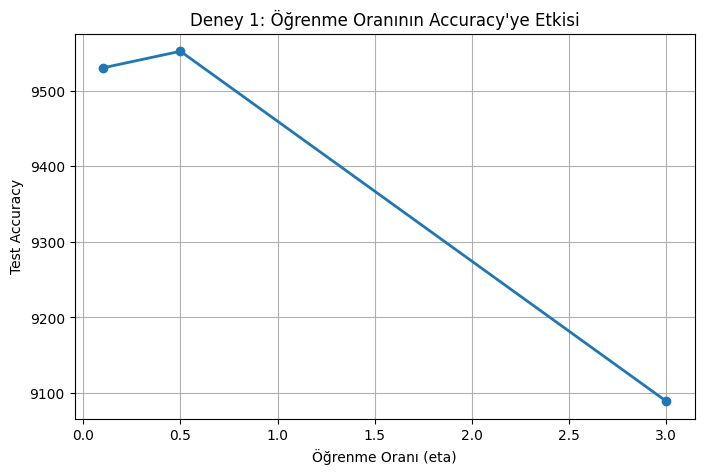

Deney 1 - Accuracy Sonuçları:
eta = 0.1 --> 9530 / 10000
eta = 0.5 --> 9552 / 10000
eta = 3.0 --> 9089 / 10000


In [ ]:
# Hücre B: Deney 1 - Öğrenme oranı grafik çıktısı

eta_values = [0.1, 0.5, 3.0]
eta_accs = [acc_eta_01, acc_eta_05, acc_eta_30]

plt.figure(figsize=(8,5))
plt.plot(eta_values, eta_accs, marker='o', linewidth=2)
plt.title("Deney 1: Öğrenme Oranının Accuracy'ye Etkisi")
plt.xlabel("Öğrenme Oranı (eta)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

print("Deney 1 - Accuracy Sonuçları:")
for eta, acc in zip(eta_values, eta_accs):
    print(f"eta = {eta} --> {acc} / {len(test_data)}")


🔹 Cell 7 – Experiment 2: Effect of mini-batch size

In this cell:

We change the mini_batch_size (10, 50, 100),

The learning rate (η), number of epochs, lambda, and network architecture remain fixed,

For each experiment, we reset and retrain the network from scratch.

In [ ]:
# Hücre 7: Deney 2 - Mini-batch boyutunun etkisi

def run_experiment_batch(batch_size, epochs=5):
    """
    Belirli bir mini_batch_size için ağı baştan kurar,
    eğitir ve son test doğruluğunu döner.
    """
    print(f"\n=== Deney 2 - Mini-batch boyutu: {batch_size} ===")

    net = Network([784, 30, 10], cost=CrossEntropyCost)

    net.SGD(
        training_data,
        epochs=epochs,
        mini_batch_size=batch_size,
        eta=0.5,           # sabit
        lmbda=5.0,         # sabit
        evaluation_data=test_data,
        monitor_evaluation_accuracy=True
    )

    final_acc = net.accuracy(test_data)
    print(f"Son test doğruluğu: {final_acc} / {len(test_data)}")
    return final_acc

# Farklı mini-batch boyutları
acc_batch_10  = run_experiment_batch(10, epochs=5)
acc_batch_50  = run_experiment_batch(50, epochs=5)
acc_batch_100 = run_experiment_batch(100, epochs=5)

print("\nÖzet (Deney 2 - mini_batch_size):")
print("batch = 10  ->", acc_batch_10,  "/", len(test_data))
print("batch = 50  ->", acc_batch_50,  "/", len(test_data))
print("batch = 100 ->", acc_batch_100, "/", len(test_data))



=== Deney 2 - Mini-batch boyutu: 10 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9433 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9490 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9538 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9550 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9545 / 10000
Son test doğruluğu: 9545 / 10000

=== Deney 2 - Mini-batch boyutu: 50 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9239 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9384 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9487 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9504 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9538 / 10000
Son test doğruluğu: 9538 / 10000

=== Deney 2 - Mini-batch boyutu: 100 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9176 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9295 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9347 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9388 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9447 / 10000
Son test doğruluğu: 9447 / 100

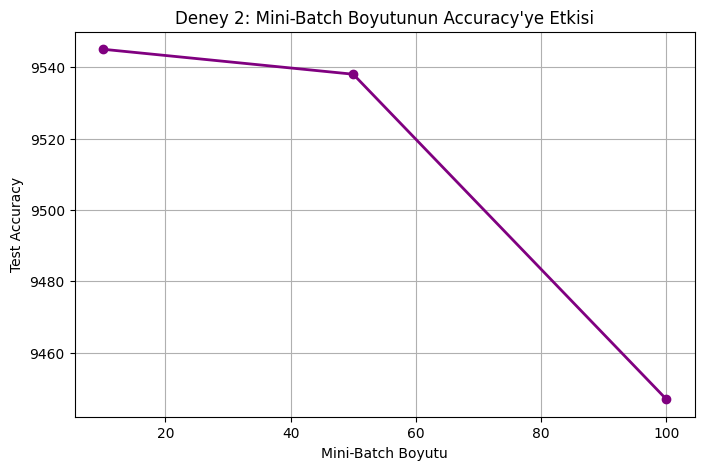

Deney 2 - Accuracy Sonuçları:
batch = 10 --> 9545 / 10000
batch = 50 --> 9538 / 10000
batch = 100 --> 9447 / 10000


In [ ]:
# Hücre C: Deney 2 - Mini-batch boyutu grafiği

batch_values = [10, 50, 100]
batch_accs = [acc_batch_10, acc_batch_50, acc_batch_100]

plt.figure(figsize=(8,5))
plt.plot(batch_values, batch_accs, marker='o', linewidth=2, color="purple")
plt.title("Deney 2: Mini-Batch Boyutunun Accuracy'ye Etkisi")
plt.xlabel("Mini-Batch Boyutu")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

print("Deney 2 - Accuracy Sonuçları:")
for b, acc in zip(batch_values, batch_accs):
    print(f"batch = {b} --> {acc} / {len(test_data)}")


🔹 Cell 8 – Experiment 3: Effect of the number of neurons in the hidden layer

In this cell:

We change the network architecture to [784, hidden_size, 10],

We test different hidden_size values: 16, 30, 64,

All other parameters (learning rate, batch size, epochs, lambda) remain constant.

In [ ]:
# Hücre 8: Deney 3 - Gizli katmandaki nöron sayısının etkisi

def run_experiment_hidden(hidden_size, epochs=5):
    """
    Belirli bir gizli katman boyutu (hidden_size) için ağı baştan kurar,
    eğitir ve son test doğruluğunu döner.
    """
    print(f"\n=== Deney 3 - Gizli katman boyutu: {hidden_size} ===")

    net = Network([784, hidden_size, 10], cost=CrossEntropyCost)

    net.SGD(
        training_data,
        epochs=epochs,
        mini_batch_size=10,   # sabit
        eta=0.5,              # sabit
        lmbda=5.0,            # sabit
        evaluation_data=test_data,
        monitor_evaluation_accuracy=True
    )

    final_acc = net.accuracy(test_data)
    print(f"Son test doğruluğu: {final_acc} / {len(test_data)}")
    return final_acc

# Farklı gizli katman boyutları
acc_hidden_16 = run_experiment_hidden(16, epochs=5)
acc_hidden_30 = run_experiment_hidden(30, epochs=5)
acc_hidden_64 = run_experiment_hidden(64, epochs=5)

print("\nÖzet (Deney 3 - hidden layer size):")
print("hidden = 16 ->", acc_hidden_16, "/", len(test_data))
print("hidden = 30 ->", acc_hidden_30, "/", len(test_data))
print("hidden = 64 ->", acc_hidden_64, "/", len(test_data))



=== Deney 3 - Gizli katman boyutu: 16 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9108 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9231 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9289 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9275 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9305 / 10000
Son test doğruluğu: 9305 / 10000

=== Deney 3 - Gizli katman boyutu: 30 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9404 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9514 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9493 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9535 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9523 / 10000
Son test doğruluğu: 9523 / 10000

=== Deney 3 - Gizli katman boyutu: 64 ===
Epoch 1/5 tamamlandı
  Test doğruluğu: 9566 / 10000
Epoch 2/5 tamamlandı
  Test doğruluğu: 9641 / 10000
Epoch 3/5 tamamlandı
  Test doğruluğu: 9643 / 10000
Epoch 4/5 tamamlandı
  Test doğruluğu: 9704 / 10000
Epoch 5/5 tamamlandı
  Test doğruluğu: 9701 / 10000
Son test doğruluğu: 9701 

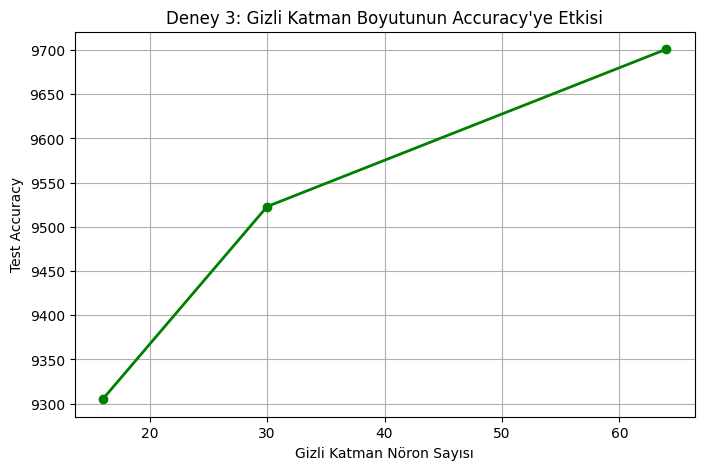

Deney 3 - Accuracy Sonuçları:
hidden = 16 --> 9305 / 10000
hidden = 30 --> 9523 / 10000
hidden = 64 --> 9701 / 10000


In [ ]:
# Hücre D: Deney 3 - Gizli nöron sayısı grafiği

hidden_values = [16, 30, 64]
hidden_accs = [acc_hidden_16, acc_hidden_30, acc_hidden_64]

plt.figure(figsize=(8,5))
plt.plot(hidden_values, hidden_accs, marker='o', linewidth=2, color="green")
plt.title("Deney 3: Gizli Katman Boyutunun Accuracy'ye Etkisi")
plt.xlabel("Gizli Katman Nöron Sayısı")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

print("Deney 3 - Accuracy Sonuçları:")
for h, acc in zip(hidden_values, hidden_accs):
    print(f"hidden = {h} --> {acc} / {len(test_data)}")


In [ ]:
# Hücre J: Hiperparametre deneylerinin özet tablosu

import pandas as pd

summary_rows = [
    ("Learning rate", "eta = 0.1",  acc_eta_01),
    ("Learning rate", "eta = 0.5",  acc_eta_05),
    ("Learning rate", "eta = 3.0",  acc_eta_30),
    ("Batch size",    "batch = 10", acc_batch_10),
    ("Batch size",    "batch = 50", acc_batch_50),
    ("Batch size",    "batch = 100",acc_batch_100),
    ("Hidden units",  "hidden = 16",acc_hidden_16),
    ("Hidden units",  "hidden = 30",acc_hidden_30),
    ("Hidden units",  "hidden = 64",acc_hidden_64),
]

df_summary = pd.DataFrame(summary_rows, columns=["Experiment", "Setting", "Correct Predictions"])

df_summary["Total Test Samples"] = len(test_data)
df_summary["Accuracy (%)"] = df_summary["Correct Predictions"] / len(test_data) * 100

df_summary


,Experiment,Setting,Correct Predictions,Total Test Samples,Accuracy (%)
0,Learning rate,eta = 0.1,9530,10000,95.30
1,Learning rate,eta = 0.5,9552,10000,95.52
2,Learning rate,eta = 3.0,9089,10000,90.89
3,Batch size,batch = 10,9545,10000,95.45
4,Batch size,batch = 50,9538,10000,95.38
5,Batch size,batch = 100,9447,10000,94.47
6,Hidden units,hidden = 16,9305,10000,93.05
7,Hidden units,hidden = 30,9523,10000,95.23
8,Hidden units,hidden = 64,9701,10000,97.01


In [ ]:
# Hücre K: En iyi hiperparametre ayarlarını otomatik bulma

# 1) En iyi öğrenme oranı
eta_values = [0.1, 0.5, 3.0]
eta_accs   = [acc_eta_01, acc_eta_05, acc_eta_30]
best_eta_idx = int(np.argmax(eta_accs))
best_eta = eta_values[best_eta_idx]

# 2) En iyi batch size
batch_values = [10, 50, 100]
batch_accs   = [acc_batch_10, acc_batch_50, acc_batch_100]
best_batch_idx = int(np.argmax(batch_accs))
best_batch = batch_values[best_batch_idx]

# 3) En iyi hidden size
hidden_values = [16, 30, 64]
hidden_accs   = [acc_hidden_16, acc_hidden_30, acc_hidden_64]
best_hidden_idx = int(np.argmax(hidden_accs))
best_hidden = hidden_values[best_hidden_idx]

print("===== Hyperparameter Summary =====")
print(f"Best learning rate (eta): {best_eta} "
      f"--> {eta_accs[best_eta_idx]} / {len(test_data)} ({eta_accs[best_eta_idx]/len(test_data)*100:.2f}%)")
print(f"Best mini-batch size:    {best_batch} "
      f"--> {batch_accs[best_batch_idx]} / {len(test_data)} ({batch_accs[best_batch_idx]/len(test_data)*100:.2f}%)")
print(f"Best hidden units:       {best_hidden} "
      f"--> {hidden_accs[best_hidden_idx]} / {len(test_data)} ({hidden_accs[best_hidden_idx]/len(test_data)*100:.2f}%)")


===== Hyperparameter Summary =====
Best learning rate (eta): 0.5 --> 9552 / 10000 (95.52%)
Best mini-batch size:    10 --> 9545 / 10000 (95.45%)
Best hidden units:       64 --> 9701 / 10000 (97.01%)


In [ ]:
# Hücre E: 3 deneyin toplu tablo çıktısı

import pandas as pd

df = pd.DataFrame({
    "Deney": [
        "Öğrenme Oranı 0.1", "Öğrenme Oranı 0.5", "Öğrenme Oranı 3.0",
        "Batch 10", "Batch 50", "Batch 100",
        "Hidden 16", "Hidden 30", "Hidden 64"
    ],
    "Accuracy": [
        acc_eta_01, acc_eta_05, acc_eta_30,
        acc_batch_10, acc_batch_50, acc_batch_100,
        acc_hidden_16, acc_hidden_30, acc_hidden_64
    ]
})

df


,Deney,Accuracy
0,Öğrenme Oranı 0.1,9530
1,Öğrenme Oranı 0.5,9552
2,Öğrenme Oranı 3.0,9089
3,Batch 10,9545
4,Batch 50,9538
5,Batch 100,9447
6,Hidden 16,9305
7,Hidden 30,9523
8,Hidden 64,9701
